In [1]:
%matplotlib inline
import os
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from tcre.env import *
from tcre import supervision 
classes = supervision.get_candidate_classes()

In [2]:
df = pd.concat([
    #pd.read_csv(osp.join(RESULTS_DATA_DIR, 'modeling-est-dev', 'run1', 'scores.csv')).assign(grp='std-dev'),
    pd.read_csv(osp.join(RESULTS_DATA_DIR, 'modeling-est-dev', 'run2', 'scores.csv')).assign(grp='std-dev'),
    pd.read_csv(osp.join(RESULTS_DATA_DIR, 'modeling-rnn-dev', 'run3', 'scores.csv')).assign(grp='rnn-dev'),
    pd.read_csv(osp.join(RESULTS_DATA_DIR, 'modeling-rnn-all', 'run3', 'scores.csv')).assign(grp='rnn-all')
], sort=True)
df.head()

,grp,metric,model,split,task,value
0,std-dev,f1,gbr,validation,inducing_cytokine,0.720000
1,std-dev,accuracy,gbr,validation,inducing_cytokine,0.750000
2,std-dev,precision,gbr,validation,inducing_cytokine,0.818182
3,std-dev,recall,gbr,validation,inducing_cytokine,0.642857
4,std-dev,roc_auc,gbr,validation,inducing_cytokine,0.742347


In [3]:
df.groupby(['task', 'grp', 'split'])['metric'].nunique().unstack()

split                                  test  training  validation
task                          grp                                
inducing_cytokine             rnn-all    11        11          11
                              rnn-dev    11        11          11
                              std-dev     6         6           6
inducing_transcription_factor rnn-all    11        11          11
                              rnn-dev    11        11          11
                              std-dev     6         6           6
secreted_cytokine             rnn-all    11        11          11
                              rnn-dev    11        11          11
                              std-dev     6         6           6

In [4]:
def get_plot(df, metric, rand_baseline=.5, pos_baseline=.66):
    return (
        pn.ggplot(
            df
                .pipe(lambda df: df[df['metric'] == metric])
                .assign(model=lambda df: pd.Categorical(
                    df['model'], ordered=True, 
                    # Average across tasks
                    categories=df[df['split'] == 'test'].groupby(['metric', 'model'])['value'].mean().loc[metric].sort_values().index
                ))
                .assign(type=lambda df: df['grp'].map({
                    'rnn-all': 'RNN (Weak)',
                    'rnn-dev': 'RNN (Strong)',
                    'std-dev': 'Sentence-Level Models'
                }))
                .assign(label=lambda df: df['value'].apply(lambda v: f'{100*v:.1f}'))
            ,
            pn.aes(x='model', y='value', fill='type', label='label')
        ) + 
        pn.geom_bar(stat='identity', position='dodge', alpha=.5) +
        pn.geom_text(va='top', size=10) + 
        pn.facet_grid('task ~ split') +
        pn.coord_cartesian(ylim = (.45, 1)) + 
        pn.geom_hline(yintercept=pos_baseline, linetype='solid') + 
        pn.geom_hline(yintercept=rand_baseline, linetype='dashed') +
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 8))
    )

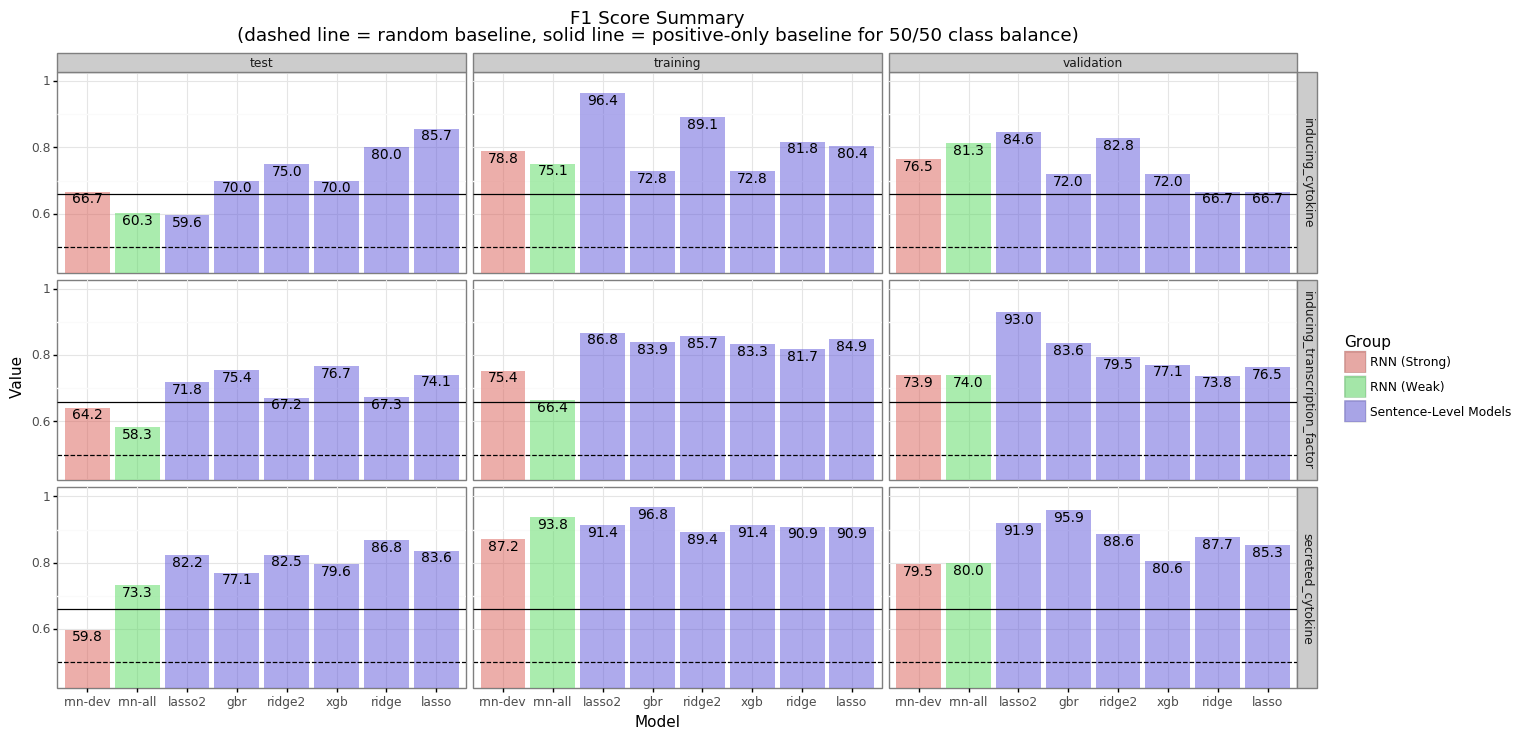

<ggplot: (8742926646613)>

In [5]:
get_plot(df, 'f1') + pn.labs(
    x='Model', y='Value', fill='Group',
    title='F1 Score Summary\n(dashed line = random baseline, solid line = positive-only baseline for 50/50 class balance)'
)

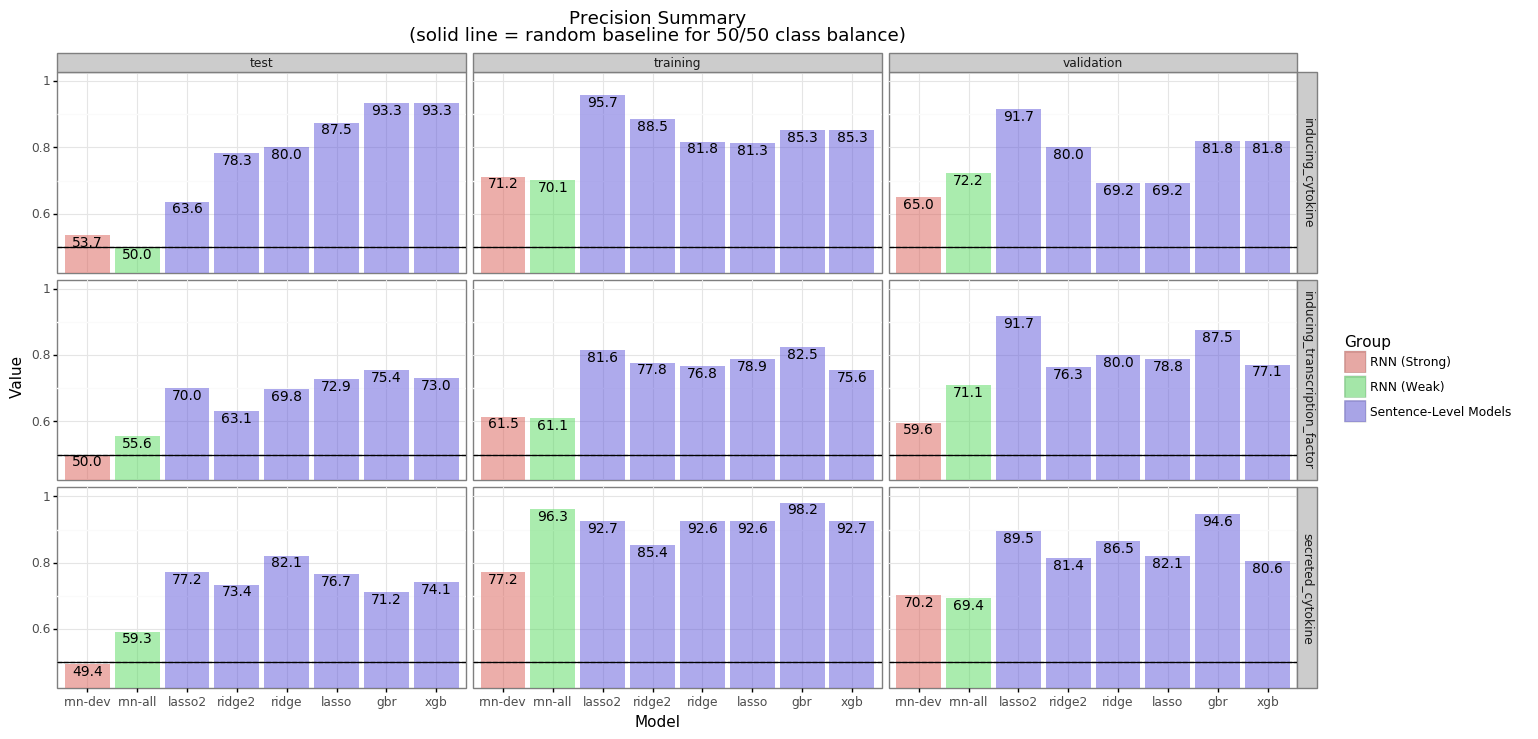

<ggplot: (8742823475688)>

In [7]:
get_plot(df, 'precision', pos_baseline=.5) + pn.labs(
    x='Model', y='Value', fill='Group',
    title='Precision Summary\n(solid line = random baseline for 50/50 class balance)'
)